In [1]:
import pandas as pd
from math import sqrt

from ProjectTools import OpenBeds
from ProjectTools import FeatIntersects

In [4]:
dry = True

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_hmc_df = filter_on_depth(nano_hmc_df)

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    nano_hmc_df = filter_on_depth(nano_hmc_df)

In [12]:
from pybedtools import BedTool

ref_features = BedTool('./feature_references/fig4_features.bed')
intergenic_bed = BedTool('./feature_references/fig4_features/interfeature.bed')

mc_bed = BedTool.from_dataframe(pd.concat([nano_mc_df, wgbs_df]))
hmc_bed = BedTool.from_dataframe(pd.concat([tab_df, nano_hmc_df]))

In [13]:
def findNamedIntersects(mod_bed, ref_features_bed, intergenic_bed):
    features_df = BedTool.intersect(mod_bed, ref_features_bed, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", "dup1", "dup2", "dup3", "feature_name", "feature_type"])
    features_df.loc[features_df["feature_type"].str.contains("CpG"), "feature_type"] = "CGI"
    intergenic_df = BedTool.intersect(mod_bed, intergenic_bed, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", "dup1", "dup2", "dup3", "feature_name", "feature_type"])

    return pd.concat([features_df, intergenic_df]).drop(columns=["dup1", "dup2", "dup3"])



In [14]:
from sklearn import preprocessing

mc_intersects_df = findNamedIntersects(mc_bed, ref_features, intergenic_bed)
hmc_intersects_df = findNamedIntersects(hmc_bed, ref_features, intergenic_bed)

hmc_intersects_df.loc[hmc_intersects_df["method"] == "Nanopore 5hmC", "method"] = "Nanopore"
mc_intersects_df.loc[mc_intersects_df["method"] == "Nanopore 5mC", "method"] = "Nanopore"

mc_averages_df = mc_intersects_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index()
hmc_averages_df = hmc_intersects_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index()

mc_averages_df.loc[mc_averages_df["percentMeth"] > 0, "binarised"] = "5mC present"
mc_averages_df.loc[mc_averages_df["percentMeth"] == 0, "binarised"] = "5mC absent"

hmc_averages_df.loc[hmc_averages_df["percentMeth"] > 0, "binarised"] = "5hmC present"
hmc_averages_df.loc[hmc_averages_df["percentMeth"] == 0, "binarised"] = "5hmC absent"

In [21]:
mc_averages_df.loc[mc_averages_df["binarised"] == "5mC present"]

,feature_name,feature_type,method,percentMeth,binarised
0,ENSMUSR00000000054,Enhancer,Nanopore,4.743571,5mC present
1,ENSMUSR00000000054,Enhancer,WGBS,7.142857,5mC present
2,ENSMUSR00000000095,Promoter,Nanopore,7.219043,5mC present
3,ENSMUSR00000000095,Promoter,WGBS,7.829861,5mC present
4,ENSMUSR00000000102,Promoter,Nanopore,8.553504,5mC present
...,...,...,...,...,...
43128,NR_169309.2_intron_2_0_chr1_52576366_f,Intron,WGBS,85.531818,5mC present
43129,NR_169309.2_intron_3_0_chr1_52591761_f,Intron,Nanopore,84.875085,5mC present
43130,NR_169309.2_intron_3_0_chr1_52591761_f,Intron,WGBS,84.664894,5mC present
43131,NR_169309.2_intron_4_0_chr1_52609278_f,Intron,Nanopore,80.692148,5mC present


/tmp/ipykernel_620365/2558583865.py:24: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(hmc_averages_df.loc[hmc_averages_df["binarised"] == "5hmC present"],


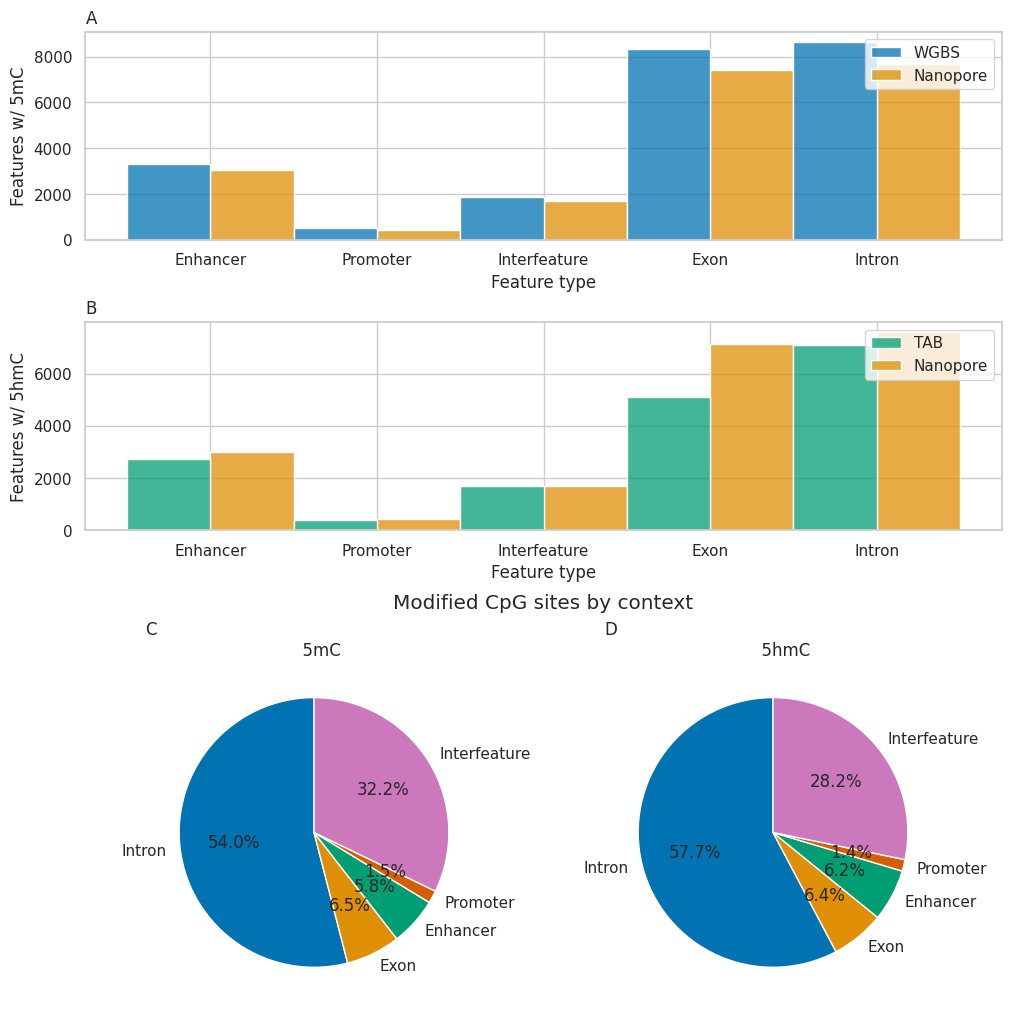

In [19]:
import seaborn as sns
import matplotlib.pyplot as pl
from matplotlib import gridspec
import matplotlib.patches as mpatches

sns.set_theme(style="whitegrid")

fig = pl.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 2, fig, height_ratios=[1, 1, 2])

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

fig2 = fig.add_subfigure(gs[2, :])
gs2 = gridspec.GridSpec(1, 2, fig2)

ax3 = fig2.add_subplot(gs2[0, 0])
ax4 = fig2.add_subplot(gs2[0, 1])

sns.histplot(mc_averages_df.loc[mc_averages_df["binarised"] == "5mC present"], 
             x="feature_type", hue="method", multiple="dodge", palette=sns.color_palette("colorblind", 2), stat="count", hue_order=("WGBS", "Nanopore"), ax=ax1)
ax1.set_title("A", loc="left")

sns.histplot(hmc_averages_df.loc[hmc_averages_df["binarised"] == "5hmC present"], 
             x="feature_type", hue="method", multiple="dodge", palette=sns.color_palette("colorblind", 3)[::-1], stat="count", hue_order=("TAB", "Nanopore"), ax=ax2)
ax2.set_title("B", loc="left")

sns.move_legend(loc="upper right", title=None, obj=ax1)
sns.move_legend(loc="upper right", title=None, obj=ax2)
ax1.set_ylabel("Features w/ 5mC")
ax2.set_ylabel("Features w/ 5hmC")
ax1.set_xlabel("Feature type")
ax2.set_xlabel("Feature type")

labels = mc_intersects_df.loc[mc_intersects_df["percentMeth"] > 0, "feature_type"].value_counts().reindex(['Intron', 'Exon', 'Enhancer', 'Promoter', 'Interfeature']).index

ax3.pie(mc_intersects_df.loc[mc_intersects_df["percentMeth"] > 0, "feature_type"].value_counts().reindex(['Intron', 'Exon', 'Enhancer', 'Promoter', 'Interfeature']), 
        labels=labels,
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette("colorblind", 5))
ax3.set_title("C\n                              5mC", loc="left")

ax4.pie(hmc_intersects_df.loc[hmc_intersects_df["percentMeth"] > 0, "feature_type"].value_counts().reindex(['Intron', 'Exon', 'Enhancer', 'Promoter', 'Interfeature']), 
        labels=labels,
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette("colorblind", 5))
ax4.set_title("D\n                              5hmC", loc="left")

fig2.suptitle("Modified CpG sites by context")

fig.set_constrained_layout(True)
fig.show()

In [20]:
hmc_intersects_df.loc[hmc_intersects_df["percentMeth"] > 0, "feature_type"].value_counts()

Intron          730059
Interfeature    357003
Exon             80957
Enhancer         78750
Promoter         17609
Name: feature_type, dtype: int64